# Stacking
## Stacking lightGBM
### Libray importing & etc

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

In [6]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option('display.precision', 4)
warnings.simplefilter('ignore')

### Data loading

In [7]:
data_dir = Path('../data/dacon-dku')
feature_dir = Path('../build/feature')
val_dir = Path('../build/val')
tst_dir = Path('../build/tst')
sub_dir = Path('../build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [8]:
algo_name = 'lgbcv'
feature_name = 'stacking1'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

### Stacking Feature 생성

In [13]:
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']
trn = []
tst = []
feature_names = []

for model in model_names:
    trn.append(np.loadtxt(val_dir/f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir/f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']

trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcv_polyfeature_class0',
 'lrcv_polyfeature_class1',
 'lrcv_polyfeature_class2',
 'rfcv_feature_class0',
 'rfcv_feature_class1',
 'rfcv_feature_class2',
 'lgbcv_feature_class0',
 'lgbcv_feature_class1',
 'lgbcv_feature_class2']

In [14]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

### Stratified K-Fold Cross Validation

In [16]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

### LightGBM Training

In [19]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')

    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1
                             )

    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)                             

    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.835905
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.723996
[3]	valid_0's multi_logloss: 0.635808
[4]	valid_0's multi_logloss: 0.564521
[5]	valid_0's multi_logloss: 0.505956
[6]	valid_0's multi_logloss: 0.457302
[7]	valid_0's multi_logloss: 0.416532
[8]	valid_0's multi_logloss: 0.38213
[9]	valid_0's multi_logloss: 0.352832
[10]	valid_0's multi_logloss: 0.327875
[11]	valid_0's multi_logloss: 0.306478
[12]	valid_0's multi_logloss: 0.288124
[13]	valid_0's multi_logloss: 0.272344
[14]	valid_0's multi_logloss: 0.258717
[15]	valid_0's multi_logloss: 0.246967
[16]	valid_0's multi_logloss: 0.236701
[17]	valid_0's multi_logloss: 0.227854
[18]	valid_0's multi_logloss: 0.22014
[19]	valid_0's multi_logloss: 0.213384
[20]	valid_0's multi_logloss: 0.207487
[21]	valid_0's multi_logloss: 0.202347
[22]	valid_0's multi_logloss: 0.197849
[23]	valid_0's multi_logloss: 0.193861
[24]	valid_0's multi_logloss

In [20]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1))*100:.4f}%')

93.1363%


In [21]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [23]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

### Feature importance Visualization

In [24]:
clf.coef_.shape

AttributeError: 'LGBMClassifier' object has no attribute 'coef_'

<AxesSubplot:ylabel='feature'>

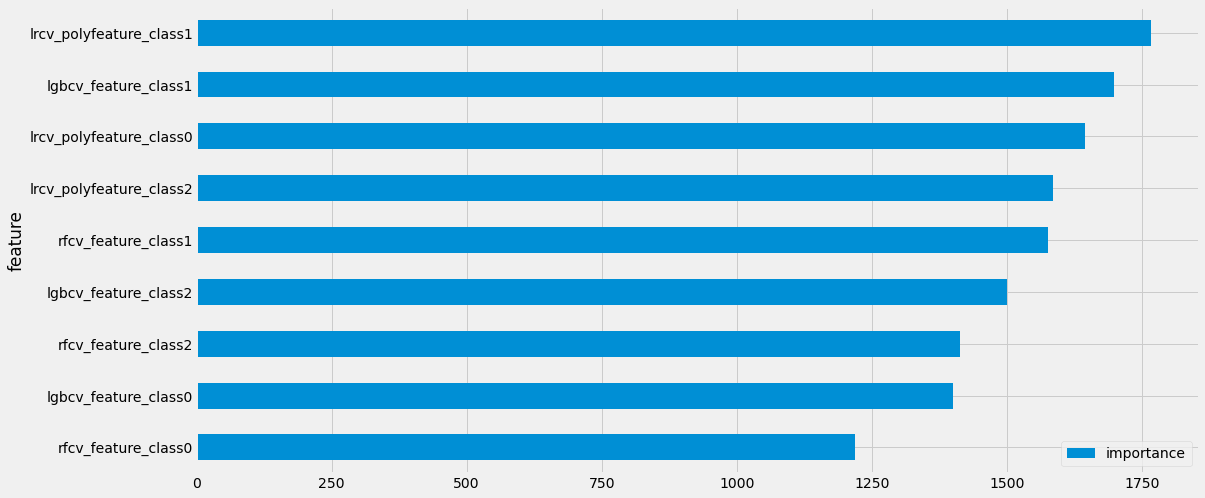

In [26]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### Submission file Creation

In [28]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [29]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [30]:
sub[target_col].value_counts()

2    41090
0    29977
1     8933
Name: class, dtype: int64

In [31]:
sub.to_csv(sub_file)

##  Logistic Regression

In [32]:
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']

In [33]:
algo_name = 'lrcv'
feature_name = 'stacking1'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

### Stacking Feature 생성

In [34]:
trn = []; tst = []

for model in model_names:
    trn.append(np.loadtxt(val_dir/f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir/f'{model}.tst.csv', delimiter=','))

trn = np.hstack(trn)
tst = np.hstack(tst)
print(trn.shape, tst.shape)

(320000, 9) (80000, 9)


In [36]:
feature_names = []
for model in model_names:
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']

feature_names    

['lrcv_polyfeature_class0',
 'lrcv_polyfeature_class1',
 'lrcv_polyfeature_class2',
 'rfcv_feature_class0',
 'rfcv_feature_class1',
 'rfcv_feature_class2',
 'lgbcv_feature_class0',
 'lgbcv_feature_class1',
 'lgbcv_feature_class2']

In [37]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

### Stratified K-Fold Cross Validation

In [38]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

### Logistic Regression Training

In [39]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV#{i}')

    clf = LogisticRegression(multi_class='multinomial')
    clf.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV#1
training model for CV#2
training model for CV#3
training model for CV#4
training model for CV#5


In [40]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1))*100:.4f}%')

93.0975%


In [41]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [42]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

### Feature importance Visualization

In [43]:
clf.coef_.shape

(3, 9)

<AxesSubplot:ylabel='feature'>

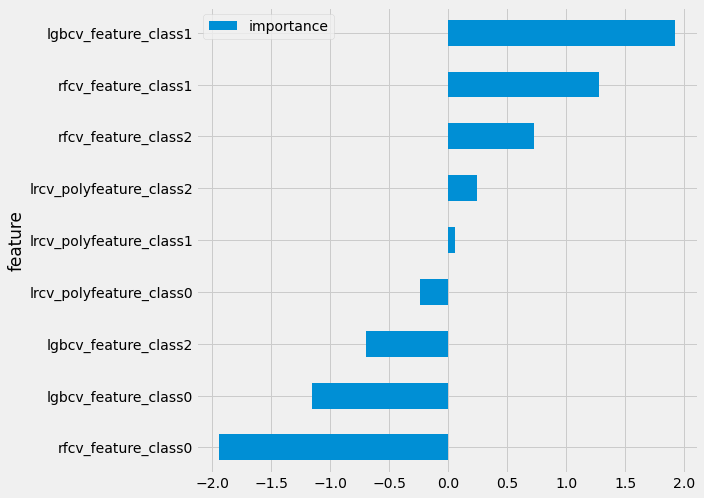

In [44]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.coef_[1,:].T})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh', figsize=(8,8))

### Submission file Creation

In [46]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [47]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [48]:
sub[target_col].value_counts()

2    41219
0    29970
1     8811
Name: class, dtype: int64

In [49]:
sub.to_csv(sub_file)